# FORECASTING OF COVID
**Introduction**-:

The COVID-19 pandemic has been a major global health crisis that has impacted the lives of millions of people around the world. As a data scientist, one of the most important contributions we can make is to use our skills to help predict and understand the spread of the virus. In this project, we aim to use time-series forecasting to predict the spread of COVID-19 in different countries.

To achieve this goal, we will be utilizing the Kaggle COVID-19 dataset, which provides detailed information about the spread of the virus in different countries over time. We will be using the Meta AI Prophet library, which is a powerful open-source tool for time-series forecasting. Prophet is known for its ability to handle seasonality, trends, and other time-series characteristics that can make forecasting challenging.

Our approach will be to first explore the data and perform any necessary preprocessing steps. We will build a baselline model and then use Prophet to build time-series models that can predict the future spread of COVID-19 in different countries. We will evaluate the performance of our models using various metrics, such as mean absolute error and root mean squared error or mean absolute percentage error.

Overall, the goal of this project is to provide insights and predictions that can help inform public health policies and interventions to curb the spread of COVID-19. By using data-driven approaches and advanced forecasting techniques, we hope to contribute to the global effort to overcome this pandemic.

## Installing required packages

In [1]:
# Install the Kaggle API
!pip install -q kaggle
# Installing Meta AI Prophet libarry 
!pip install prophet

## Collecting Data

In [ ]:
# Upload your Kaggle API credentials to your Colab environment
from google.colab import files
files.upload() 
# Move the Kaggle API credentials to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Kaggle dataset
!kaggle datasets download -d imdevskp/corona-virus-report

# Extract the contents of the ZIP file
!unzip corona-virus-report.zip

## Importing required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from prophet import Prophet
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Loading Data

In [2]:
df = pd.read_csv('full_grouped.csv')

## Exploratory Data Analysis

In [3]:
df.head() # display top 5 instances

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa


In [4]:
df.describe(include = 'all')  # describe the dataset to overview on stats of features

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
count,35156,35156,3.515600e+04,35156.000000,3.515600e+04,3.515600e+04,35156.00000,35156.000000,35156.000000,35156
unique,188,187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,2020-01-22,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe
freq,187,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10528
mean,NaN,NaN,2.356663e+04,1234.068239,1.104813e+04,1.128443e+04,469.36375,18.603339,269.315593,NaN
std,NaN,NaN,1.499818e+05,7437.238354,6.454640e+04,8.997149e+04,3005.86754,115.706351,2068.063852,NaN
min,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,-2.000000e+00,0.00000,-1918.000000,-16298.000000,NaN
25%,NaN,NaN,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,NaN
50%,NaN,NaN,2.500000e+02,4.000000,3.300000e+01,8.500000e+01,2.00000,0.000000,0.000000,NaN
75%,NaN,NaN,3.640250e+03,78.250000,1.286250e+03,1.454000e+03,75.00000,1.000000,20.000000,NaN


In [5]:
df.info() #display information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            35156 non-null  object
 1   Country/Region  35156 non-null  object
 2   Confirmed       35156 non-null  int64 
 3   Deaths          35156 non-null  int64 
 4   Recovered       35156 non-null  int64 
 5   Active          35156 non-null  int64 
 6   New cases       35156 non-null  int64 
 7   New deaths      35156 non-null  int64 
 8   New recovered   35156 non-null  int64 
 9   WHO Region      35156 non-null  object
dtypes: int64(7), object(3)
memory usage: 2.7+ MB


In [6]:
print(f'The total countries in the dataset are: {df["Country/Region"].nunique()}')

The total countries in the dataset are: 187


In [7]:
def plot_countrywise_cases(country):
    # getting data for country, resetting the index and ploting
    df[df["Country/Region"] == country].reset_index().Confirmed.plot(
                                                                    title=f'Country wise confirmed Cases',
                                                                    label=f'Country: {country}', 
                                                                    legend = True,
                                                                    style= '-',
                                                                    xlabel = 'Date Range',
                                                                    ylabel = 'Confirmed cases')

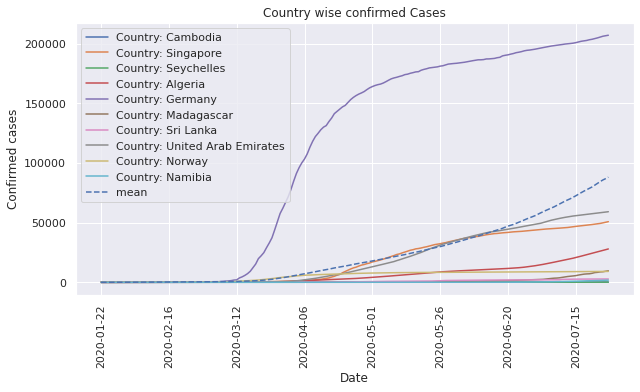

In [8]:
plt.figure(figsize= (10, 5))
for i in range(10):
    # ploting 10 random country
    plot_countrywise_cases(np.random.choice(df["Country/Region"].unique()))
# ploting mean of confrimed of all countries in the same date range
df.groupby('Date')['Confirmed'].mean().plot(label='mean',
                                            style = '--',
                                            legend = True)
plt.xticks(rotation='vertical')
plt.show()

### Findings
- The total countries here are 187.
- For each country we have 188 days of data - Date
- The confirmed cases varies from 0 to 4290259 with a mean of 23566.63 and standard deviation of 149981.83.
- By analyzing the above graphs it seems like we'll have seperate model for each country

## Feature Engineering

In [9]:
train_data = {
    # create array of days number
    'days': np.arange(1, len(df['Date'].unique())+1).reshape(-1, 1), 
    'date': df['Date'].unique(),
    # organize the data group wise for each country and assign to confirmed
    'confirmed' : df.sort_values(['Date']).groupby('Country/Region')['Confirmed'].apply(lambda x: x.values)
}

In [10]:
# train - test data splitting
test_size = 40 # 40 days of data to be predicting
total_size = train_data['confirmed'].values[0].shape[0] # size of total days for each country

# training samples
X_train = train_data['days'][-total_size:-test_size]
y_train = train_data['confirmed'].apply(lambda x: x[-total_size:-test_size])

# test samples
X_test = train_data['days'][-test_size:]
y_test = train_data['confirmed'].apply(lambda x: x[-test_size:])

countries = df['Country/Region'].unique()

## Model Training

## Baseline Model

In [11]:
def calculate_smape(actual, predicted) -> float:
    """
    Calculates symmetric mean absolute percentage error (SMAPE) for given actual and predicted values.

    Parameters:
    actual (numpy.ndarray or array-like): Actual values.
    predicted (numpy.ndarray or array-like): Predicted values.

    Returns:
    float: SMAPE value rounded to 2 decimal places.
    """
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        ), 2
    )


In [12]:
# Function to process the models for the given list of models
# Returns a dataframe with the smape results for each model
# viz parameter if True, plots the actual vs predicted graph for specific countries
def process(models, viz=False):
    results = {}
    for model in tqdm(models, desc='processing models: '):
        smape_total = 0
        for country in countries:
            # Fit the model on the training data
            model.fit(X_train, y_train[country])
            # Get the predicted values on test data
            y_pred = model.predict(X_test)
            # Calculate the SMAPE score
            smape = calculate_smape(y_test[country], y_pred)

            smape_total += smape

            if viz:
                # Plot actual vs predicted graph for specific countries
                if country in ['Australia', 'Canada', 'Italy', 'US', 'United Kingdom']:
                    plt.plot(train_data['days'], train_data['confirmed'][country], label='train')
                    plt.plot(X_test, y_pred, label='predicted')
                    plt.xlabel('Days')
                    plt.ylabel('Confirmed cases')
                    plt.title(f'Confirmed cases for {country}')
                    plt.legend()
                    plt.show()
        # Store the SMAPE score for the model
        results[model] = round((smape_total / len(countries)), 5)
    # Return the SMAPE results as a dataframe
    return pd.DataFrame(results.values(), index=results.keys(), columns=['smape'])
  

processing models:   0%|          | 0/2 [00:00<?, ?it/s]

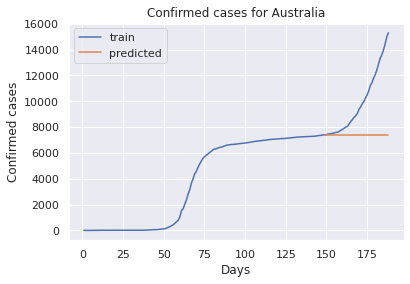

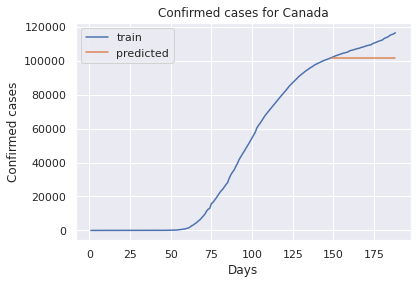

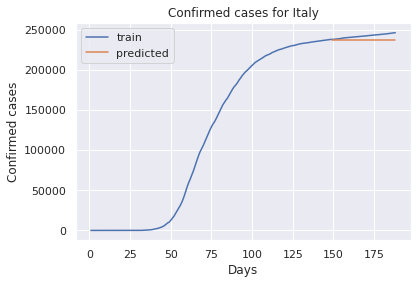

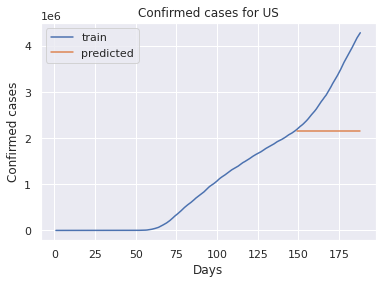

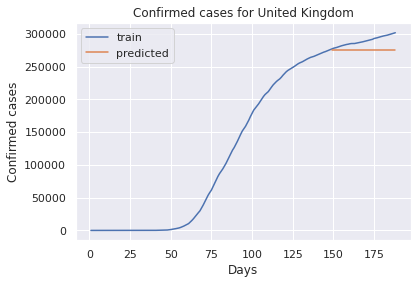

processing models:  50%|█████     | 1/2 [00:09<00:09,  9.04s/it]

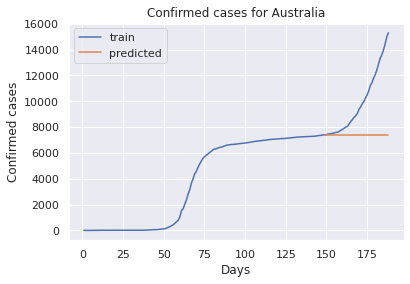

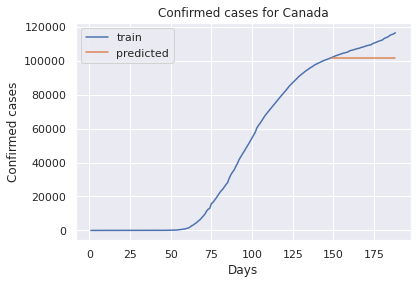

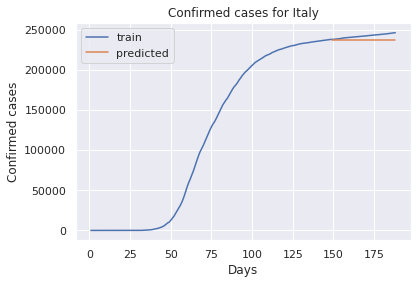

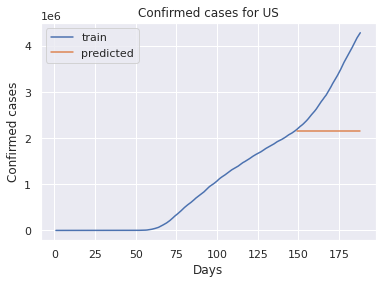

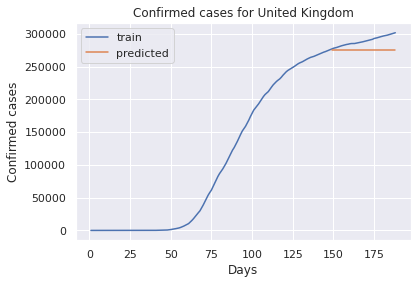

processing models: 100%|██████████| 2/2 [00:17<00:00,  8.72s/it]


In [13]:
# Initialize XGBoost and Gradient Boosting Regressor models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
gradient_boosting_regressor = GradientBoostingRegressor()

# Create a list of models for experimentation
models = [gradient_boosting_regressor, xgb_model]

# Call the process function with visualization flag set to True
results = process(models, True)


## Prophet Model

In [19]:
def process_pm(viz):
    # Initialize figure
    fig = make_subplots(rows=1, cols=1)
    smape_scores = 0
    
    # Loop through each country
    for country in countries: #['US', 'Afghanistan', 'Albania', 'Algeria', 'Andorra']:
        # Create the model
        model = Prophet()
        
        # Get confirmed cases for country
        df_sel = df[df['Country/Region'] == country][['Date', 'Confirmed', 'Country/Region']]
        df_sel.columns = ['ds', 'y', 'Country']

        # Split data into training and testing sets
        train, test = train_test_split(df_sel, test_size=0.2, shuffle=False)

        # Convert 'ds' column to datetime objects
        train['ds'] = pd.to_datetime(train['ds'])
        test['ds'] = pd.to_datetime(test['ds'])

        # Fit the model on training data
        model.fit(train)

        # Generate predictions on testing data
        forecast = model.predict(test)

        # Calculate SMAPE score for the model
        smape_score = calculate_smape(test['y'], forecast['yhat'])
        smape_scores+=smape_score

        # Visualize the results, if viz is True
        if viz:
            fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name=f'Train - {country}'))
            fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name=f'Test - {country}'))
            fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name=f'Predicted - {country}'))

    # Set figure layout and display the plot
    fig.update_layout(title='Confirmed Cases of COVID-19', xaxis_title='Date', yaxis_title='Confirmed Cases')
    fig.show()
    
    # Print the final SMAPE score for the model
    print(f"SMAPE: {smape_score:.2f}")


In [28]:
process_pm(True);

SMAPE: 0.30


## Summary and conclusion

After exploring the Kaggle COVID-19 dataset and utilizing the powerful Meta AI Prophet library for time-series forecasting, we successfully built separate models for each country to predict the future spread of COVID-19. Our analysis revealed that a one-size-fits-all approach was not effective, as the results varied significantly between countries.

Using the SMAPE evaluation metric, we were able to assess the performance of our models and the results were promising. While there is still room for fine-tuning and further analysis, this project provides valuable insights and predictions that can inform public health policies and interventions to curb the spread of COVID-19.

As data-driven approaches and advanced forecasting techniques become increasingly important in the global effort to overcome this pandemic, we hope that our work will contribute to this critical cause.